In [15]:
# Run them separately line by line without comments in the cell
# pip install -q datasets

# pip install -q emoji

# pip install -q profanity-filter

# pip install -q emoji==0.6.0

In [2]:
# pip install -q transformers

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.figure_factory as ff
from profanity_filter import ProfanityFilter
from emoji import demojize
from nltk.tokenize import TweetTokenizer


In [70]:
# https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train': 'NLP_train.csv', 'test': 'NLP_test_4k.csv', 'val': 'NLP_val_3.5k.csv'}, encoding = "ISO-8859-1")


Using custom data configuration default-3fa3477923ce537c
Reusing dataset csv (/home/azureuser/.cache/huggingface/datasets/csv/default-3fa3477923ce537c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


In [71]:
print(type(dataset))
dataset['train'][5]

<class 'datasets.dataset_dict.DatasetDict'>


{'id': 1.08e+18,
 'text': "@jingle_belle Indeed.  One of the challenges Doctors face is both that their incentives are screwed up but also that they are geared towards simple diagnoses.  This leads them to prescribing their book which doesn't work with something complicated like Lyme.",
 'label': 1,
 'fixed_text': 'indeed one of the challenges doctors face is both that their incentives are screwed up but also that they are geared towards simple diagnoses this leads them to prescribing their book which doesnt work with something complicated like lyme'}

In [72]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'fixed_text'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['fixed_text', 'id', 'label', 'text'],
        num_rows: 4000
    })
    val: Dataset({
        features: ['fixed_text', 'id', 'label', 'text'],
        num_rows: 3500
    })
})

In [73]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments



In [74]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)
tokenizer("hello my world")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


{'input_ids': [0, 2279, 23, 220, 2], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [75]:
# Source: https://github.com/VinAIResearch/BERTweet/blob/master/TweetNormalizer.py
def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    pf = ProfanityFilter()
    tweet = pf.censor(tweet)
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return {'fixed_text': " ".join(normTweet.split())}

In [76]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'fixed_text'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['fixed_text', 'id', 'label', 'text'],
        num_rows: 4000
    })
    val: Dataset({
        features: ['fixed_text', 'id', 'label', 'text'],
        num_rows: 3500
    })
})

In [77]:
def transform_labels(label):

    num = label['label']
    # num = label['keywords_label']
    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['fixed_text'], padding='max_length')

def normalize_tweet(example):
    return normalizeTweet(example['fixed_text'])

# print("dataset before tokenize:", dataset)
dataset = dataset.map(tokenize_data, batched=True)
# dataset = dataset.map(normalize_tweet)
# print("dataset after tokenize:", dataset)

# remove_columns = ['id','text','keywords_label','fixed_text']

# print("dataset before transform_labels:", dataset)
remove_columns = ['id','text','fixed_text']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/csv/default-3fa3477923ce537c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0/cache-99f51a94db305ed2.arrow
Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/csv/default-3fa3477923ce537c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0/cache-548a3c3042e1a4ff.arrow
Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/csv/default-3fa3477923ce537c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0/cache-df5334072c36a2e5.arrow
Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/csv/default-3fa3477923ce537c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0/cache-73918a24b22b0388.arrow
Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/csv/default-3fa3477923ce537c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425

In [78]:
dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'labels', 'token_type_ids'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'labels', 'token_type_ids'],
        num_rows: 4000
    })
    val: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'labels', 'token_type_ids'],
        num_rows: 3500
    })
})

In [79]:

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base")


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [80]:
# Shuffle data and make train dataset with 60,000 tweets and evaluation dataset with 10,000 tweets
# temp_ds = dataset['train'].shuffle(seed=111)
# train_dataset = temp_ds.select(range(60000))
# eval_dataset = temp_ds.select(range(60000, 70000))

train_dataset = dataset['train'].shuffle(seed=111)
eval_dataset = dataset['val'].shuffle(seed=111)
test_dataset = dataset['test'].shuffle(seed=111)

In [81]:
train_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'labels', 'token_type_ids'],
    num_rows: 70000
})

In [82]:
eval_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'labels', 'token_type_ids'],
    num_rows: 3500
})

In [83]:
dataset['train']

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'labels', 'token_type_ids'],
    num_rows: 70000
})

In [84]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [85]:
train_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'labels', 'token_type_ids'],
    num_rows: 70000
})

In [86]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [87]:
batch_size=64
epochs=10
training_args = TrainingArguments("test_trainer", num_train_epochs=epochs, 
                  learning_rate=2e-5, per_device_train_batch_size=batch_size, 
                  per_device_eval_batch_size=batch_size, weight_decay=0.01,
                  evaluation_strategy="epoch", load_best_model_at_end=True, metric_for_best_model='accuracy')

In [88]:
from sklearn.metrics import classification_report, precision_score, \
    recall_score, f1_score, accuracy_score, precision_recall_fscore_support, roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    roc = roc_auc_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc': roc
    }


In [89]:

from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model, args=training_args, compute_metrics=compute_metrics,
    train_dataset=train_dataset, eval_dataset=eval_dataset, tokenizer=tokenizer, callbacks=[EarlyStoppingCallback(early_stopping_patience=0.001)]
)

trainer.train()


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc,Runtime,Samples Per Second
1,0.177600,0.305857,0.905429,0.903131,0.951882,0.859131,0.906678,29.608200,118.211000
2,0.098700,0.372052,0.901143,0.899594,0.939394,0.863029,0.902172,29.639100,118.087000


Attempted to log scalar metric loss:
0.1776
Attempted to log scalar metric learning_rate:
1.817184643510055e-05
Attempted to log scalar metric epoch:
0.91
Attempted to log scalar metric eval_loss:
0.30585744976997375
Attempted to log scalar metric eval_accuracy:
0.9054285714285715
Attempted to log scalar metric eval_f1:
0.9031314018144572
Attempted to log scalar metric eval_precision:
0.9518815545959285
Attempted to log scalar metric eval_recall:
0.85913140311804
Attempted to log scalar metric eval_roc:
0.906678377615358
Attempted to log scalar metric eval_runtime:
29.6082
Attempted to log scalar metric eval_samples_per_second:
118.211
Attempted to log scalar metric epoch:
1.0
Attempted to log scalar metric loss:
0.0987
Attempted to log scalar metric learning_rate:
1.6343692870201096e-05
Attempted to log scalar metric epoch:
1.83
Attempted to log scalar metric eval_loss:
0.37205231189727783
Attempted to log scalar metric eval_accuracy:
0.9011428571428571
Attempted to log scalar metric 

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1094, training_loss=0.13399905652842967, metrics={'train_runtime': 3173.1989, 'train_samples_per_second': 1.724, 'total_flos': 1.450460992512e+16, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 844111872, 'init_mem_gpu_alloc_delta': 540129280, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 225243136, 'train_mem_gpu_alloc_delta': 2161684992, 'train_mem_cpu_peaked_delta': 1007583232, 'train_mem_gpu_peaked_delta': 6570923520})

In [90]:
trainer.save_model("btwoprofanemodel")

In [91]:
pred_output = trainer.predict(eval_dataset)
pred_output.metrics

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.30585744976997375,
 'test_accuracy': 0.9054285714285715,
 'test_f1': 0.9031314018144572,
 'test_precision': 0.9518815545959285,
 'test_recall': 0.85913140311804,
 'test_roc': 0.906678377615358,
 'test_runtime': 29.4808,
 'test_samples_per_second': 118.721,
 'test_mem_cpu_alloc_delta': 8192,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_cpu_peaked_delta': 36864,
 'test_mem_gpu_peaked_delta': 277320704}

In [92]:

pred_output_test = trainer.predict(test_dataset)
pred_output_test.metrics

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.31399354338645935,
 'test_accuracy': 0.90425,
 'test_f1': 0.8989179202955926,
 'test_precision': 0.9535274356103024,
 'test_recall': 0.8502246630054917,
 'test_roc': 0.9043311597451095,
 'test_runtime': 33.7976,
 'test_samples_per_second': 118.352,
 'test_mem_cpu_alloc_delta': 1236992,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_cpu_peaked_delta': 0,
 'test_mem_gpu_peaked_delta': 277330944}

In [93]:
y_preds = np.argmax(pred_output_test.predictions, axis=1)


In [94]:
# Adopted from O'Reilly Natural Language Processing with Transformers book
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_cm(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize= "true")
  flg, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax = ax)
  plt.title("Normalized Confusion Matrix")
  plt.show()




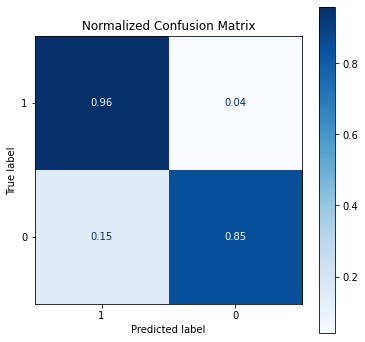

In [95]:

plot_cm(y_preds, test_dataset['labels'], test_dataset['labels'])

In [38]:
# full_dataset = load_dataset('csv', data_files={'final': 'tweets_420k.csv'}, encoding = "ISO-8859-1")
# full_dataset

temp = pd.read_csv("tweets_420k.csv")
temp = temp.text
temp.shape
# full_output.metrics
# print("test console")



/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(301233,)